In [1]:
import os
import time
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, WeightedRandomSampler
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
import timm
from sklearn.metrics import accuracy_score


In [ ]:

CFG = {
    'model_name': 'mvitv2_tiny',
    'num_classes': 2,
    'epochs': 50,
    'batch_size': 64,
    'lr': 1e-4,
    'img_size': 224,
    'data_path': 'path_to_spectrogram_dataset',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}



In [ ]:
def get_class_weights(train_dir):
    class_counts = []
    for class_dir in sorted(os.listdir(train_dir)):
        class_path = os.path.join(train_dir, class_dir)
        if os.path.isdir(class_path):
            class_counts.append(len(os.listdir(class_path)))
    
    total_samples = sum(class_counts)
    weights = [total_samples / count for count in class_counts]
    return torch.tensor(weights, dtype=torch.float32)



In [ ]:
train_transforms = T.Compose([
    T.RandomResizedCrop(CFG['img_size']),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = T.Compose([
    T.Resize(CFG['img_size'] + 32),
    T.CenterCrop(CFG['img_size']),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:

train_dataset = ImageFolder(os.path.join(CFG['data_path'], 'train'), train_transforms)
val_dataset = ImageFolder(os.path.join(CFG['data_path'], 'val'), val_transforms)


In [6]:

# Calculate class weights and create sampler
class_weights = get_class_weights(os.path.join(CFG['data_path'], 'train'))
samples_weights = class_weights[train_dataset.targets]
sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True
)

In [8]:
class_weights, samples_weights

(tensor([2.0055, 1.9945]),
 tensor([2.0055, 2.0055, 2.0055,  ..., 1.9945, 1.9945, 1.9945]))

In [9]:
# Data Loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['batch_size'],
    sampler=sampler,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [10]:
# Model
model = timm.create_model(CFG['model_name'], pretrained=True, num_classes=CFG['num_classes'])
model = model.to(CFG['device'])

# Loss Function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(CFG['device']))
optimizer = optim.AdamW(model.parameters(), lr=CFG['lr'])
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs'])

# Training Loop
best_val_acc = 0


In [ ]:
from tqdm import tqdm  # Add this import at the top of your file

# Modified training loop with progress bars
for epoch in range(CFG['epochs']):
    start_time = time.time()
    
    # Training with progress bar
    model.train()
    train_loss = 0
    train_bar = tqdm(train_loader, 
                    desc=f'Epoch {epoch+1}/{CFG["epochs"]} Training', 
                    leave=False,
                    bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    for images, labels in train_bar:
        images = images.to(CFG['device'])
        labels = labels.to(CFG['device'])
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        train_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    scheduler.step()
    
    # Validation with progress bar
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []
    val_bar = tqdm(val_loader, 
                  desc=f'Epoch {epoch+1}/{CFG["epochs"]} Validating', 
                  leave=False,
                  bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    with torch.no_grad():
        for images, labels in val_bar:
            images = images.to(CFG['device'])
            labels = labels.to(CFG['device'])
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    # Calculate metrics
    train_loss = train_loss / len(train_loader.dataset)
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = accuracy_score(all_labels, all_preds)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
    
    # Epoch summary
    print(f'Epoch {epoch+1}/{CFG["epochs"]} | '
          f'Train Loss: {train_loss:.4f} | '
          f'Val Loss: {val_loss:.4f} | '
          f'Val Acc: {val_acc:.4f} | '
          f'Time: {time.time()-start_time:.2f}s')

print(f'Best Validation Accuracy: {best_val_acc:.4f}')

In [ ]:
from tqdm import tqdm

import matplotlib.pyplot as plt

# Load model from checkpoint
model.eval()
val_loss = 0
all_preds = []
all_labels = []
val_bar = tqdm(val_loader, 
                desc=f'Validating', 
                leave=False,
                bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
with torch.no_grad():
    for images, labels in val_bar:
        images = images.to(CFG['device'])
        labels = labels.to(CFG['device'])
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        val_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        val_bar.set_postfix({'loss': f'{loss.item():.4f}'})
val_loss = val_loss / len(val_loader.dataset)
val_acc = accuracy_score(all_labels, all_preds)

Precision: 0.9698
Recall: 0.9697
F1 Score: 0.9697
Confusion Matrix:
[[18388   699]
 [  461 18731]]
ROC AUC: 0.9697


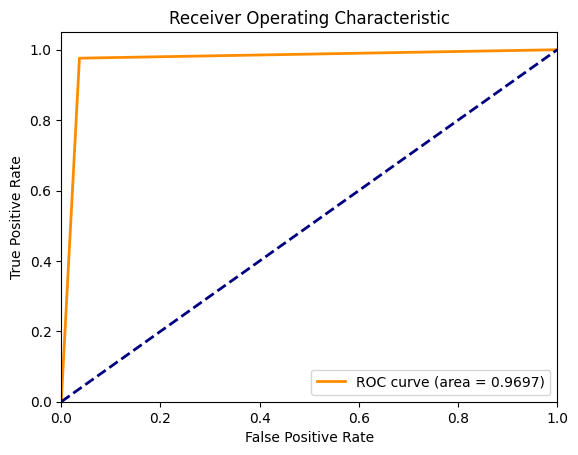

PR AUC: 0.9760


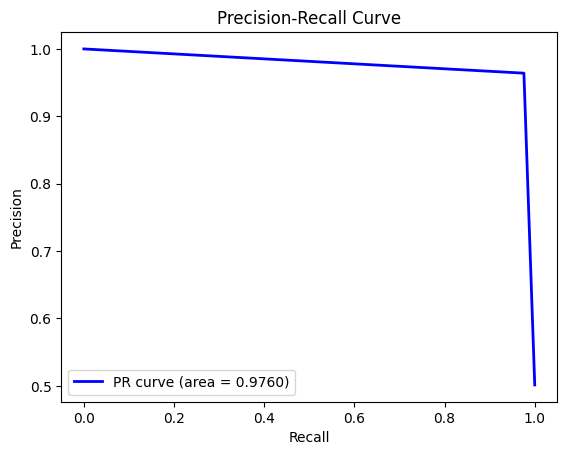

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc

# Calculate precision
precision = precision_score(all_labels, all_preds, average='weighted')
print(f'Precision: {precision:.4f}')

# Calculate recall
recall = recall_score(all_labels, all_preds, average='weighted')
print(f'Recall: {recall:.4f}')

# Calculate F1 score
f1 = f1_score(all_labels, all_preds, average='weighted')
print(f'F1 Score: {f1:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(conf_matrix)

# Calculate ROC AUC
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.4f}')

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_preds)
pr_auc = auc(recall_curve, precision_curve)
print(f'PR AUC: {pr_auc:.4f}')

# Plot Precision-Recall Curve
plt.figure()
plt.plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()